# Final Main Implementation v.2

> This is a the main CNN implementation to recognize images of sign language digits.

In [58]:
# libraries:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

### Loading and preprocessing the data

In [59]:
# Defining a CNN model
def build_cnn(input_shape=(64, 64, 1), num_classes=10):
    # Convert grayscale to RGB (MobileNetV2 expects 3 channels)
    inputs = layers.Input(shape=input_shape)
    x = layers.Concatenate()([inputs, inputs, inputs])  # Convert to 3 channels
    # x = tf.keras.applications.mobilenet_v2.preprocess_input(x)    # MobileNetV2 preprocessing

    # Load MobileNetV2 base model (without top layers)
    base_model = MobileNetV2(
        input_shape=(64, 64, 3),  # Matches your input size after conversion
        include_top=False,
        weights='imagenet',
        pooling='avg'  # GlobalAveragePooling will be applied
    )

    # Freeze base model layers initially
    base_model.trainable = False
    x = base_model(x)

    # Custom layers
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001), # Use lower learning rate for transfer learning
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [60]:
# Load images and labels
X = np.load('data/X.npy').astype('float32')
y = np.load('data/Y.npy')

In [61]:
# Add channel dimension (grayscale)
X = X.reshape(-1, 64, 64, 1)  # New shape: (2062, 64, 64, 1)

In [62]:
k = 5  # Typical value, but you can experiment
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [63]:
# Data Augmentation: helps increase the diversity of training data
# by applying random transformations like rotation and zoom
datagen = ImageDataGenerator(
    rotation_range=15,           # Randomly rotate images in the range (degrees)
    zoom_range=0.1,              # Randomly zoom images
    width_shift_range=0.1,       # Randomly shift images horizontally
    height_shift_range=0.1       # Randomly shift images vertically
)

### Main CNN Implementation with k-fold CV

In [64]:
# Lists to store history from each fold
accuracies = []
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

In [65]:
for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Convert one-hot labels to integers 
    y_train = np.argmax(y_train, axis=1)
    y_val = np.argmax(y_val, axis=1)

    # Compute any statistics required for augmentation
    datagen.fit(X_train)

    # Create and train model (you'll need to reinitialize your model each time)
    model = build_cnn()  # Your model creation function
    history = model.fit(X_train, y_train, 
                       validation_data=(X_val, y_val),
                       epochs=30, batch_size=32)
    
    # Evaluate and store accuracy
    val_acc = model.evaluate(X_val, y_val)[1]
    accuracies.append(val_acc)

    # Store metrics
    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])


/var/folders/9q/63typ5pn2hs7z2cz13vwj5j40000gn/T/ipykernel_87967/1468559717.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.1402 - loss: 2.7551 - val_accuracy: 0.2857 - val_loss: 2.0337
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2282 - loss: 2.2630 - val_accuracy: 0.4213 - val_loss: 1.7875
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3283 - loss: 1.9295 - val_accuracy: 0.4939 - val_loss: 1.6147
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3640 - loss: 1.8117 - val_accuracy: 0.5400 - val_loss: 1.4722
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4225 - loss: 1.6713 - val_accuracy: 0.5811 - val_loss: 1.3533
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4811 - loss: 1.5397 - val_accuracy: 0.6271 - val_loss: 1.2516
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4947 - loss: 1.4873 - val_accuracy: 0.6538 - val_loss: 1.1629
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5648 - loss: 1.3461 - val_accuracy: 0.6610 - v

### Viewing CNN Statistics

In [66]:
def plot_avg_accuracy(train_acc, val_acc):
    avg_train_acc = np.mean(train_acc, axis=0)
    avg_val_acc = np.mean(val_acc, axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(avg_train_acc, label='Training Accuracy')
    plt.plot(avg_val_acc, label='Validation Accuracy')
    plt.title('Average Training & Validation Accuracy Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [67]:
def plot_avg_loss(train_loss, val_loss):
    avg_train_loss = np.mean(train_loss, axis=0)
    avg_val_loss = np.mean(val_loss, axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(avg_train_loss, label='Training Loss')
    plt.plot(avg_val_loss, label='Validation Loss')
    plt.title('Average Training & Validation Loss Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [68]:
def plot_individual_folds(metric, title, ylabel):
    plt.figure(figsize=(10, 5))
    for i, fold_metric in enumerate(metric):
        plt.plot(fold_metric, label=f'Fold {i+1}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [69]:
def plot_overlaid_folds(train_metric, val_metric, metric_name):
    plt.figure(figsize=(12, 6))
    
    # Plot all training metrics
    for i, fold_metric in enumerate(train_metric):
        plt.plot(fold_metric, color='blue', alpha=0.2, linestyle='-')
    
    # Plot all validation metrics
    for i, fold_metric in enumerate(val_metric):
        plt.plot(fold_metric, color='orange', alpha=0.2, linestyle='-')
    
    # Plot averages
    plt.plot(np.mean(train_metric, axis=0), color='blue', 
             linewidth=2, label='Avg Training')
    plt.plot(np.mean(val_metric, axis=0), color='orange', 
             linewidth=2, label='Avg Validation')
    
    plt.title(f'Training & Validation {metric_name} Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

In [70]:
print(f"Average validation accuracy: {np.mean(accuracies):.2%}")

Average validation accuracy: 75.51%


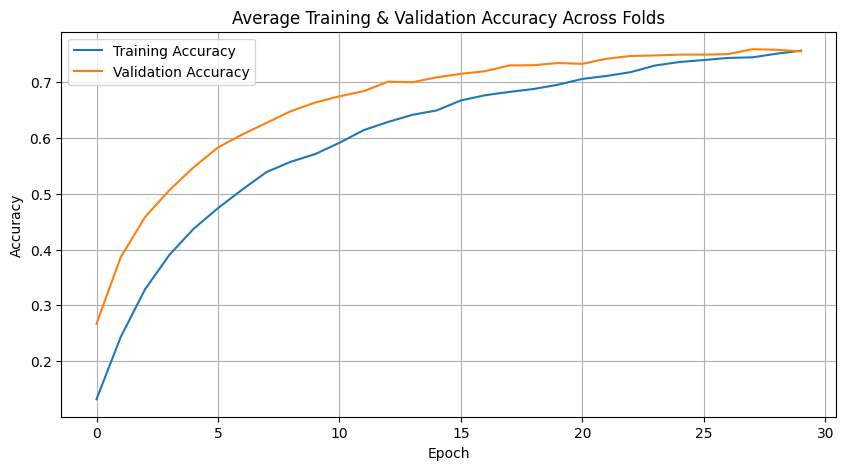

In [71]:
# Plotting average accuracy
plot_avg_accuracy(all_train_acc, all_val_acc)

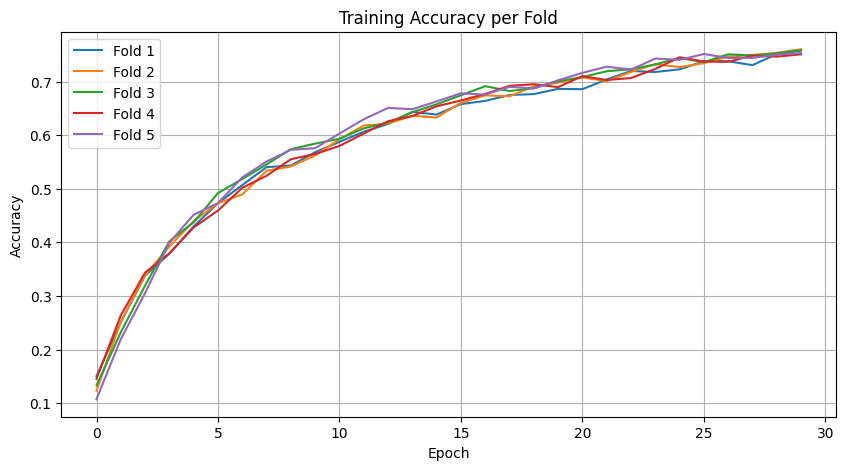

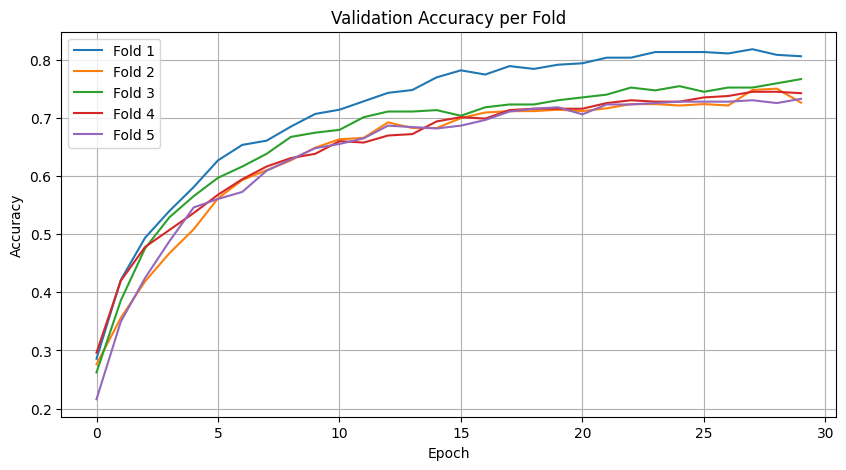

In [72]:
# Plot individual folds accuracy
plot_individual_folds(all_train_acc, 'Training Accuracy per Fold', 'Accuracy')
plot_individual_folds(all_val_acc, 'Validation Accuracy per Fold', 'Accuracy')

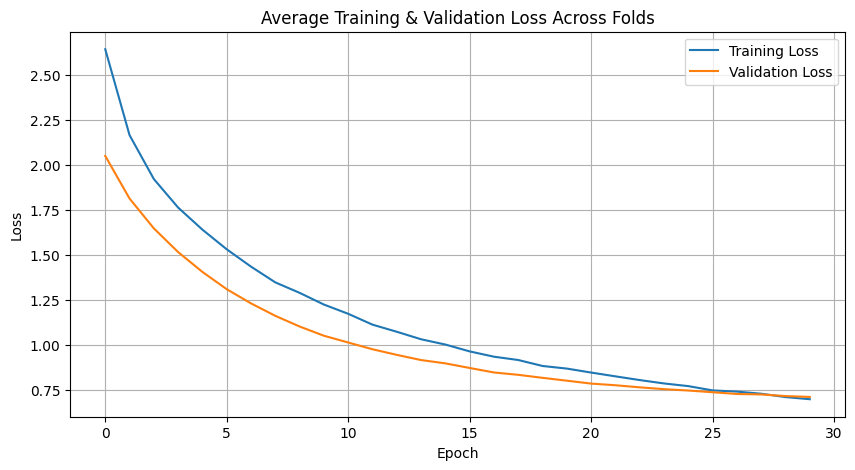

In [73]:
# Plotting average loss
plot_avg_loss(all_train_loss, all_val_loss)

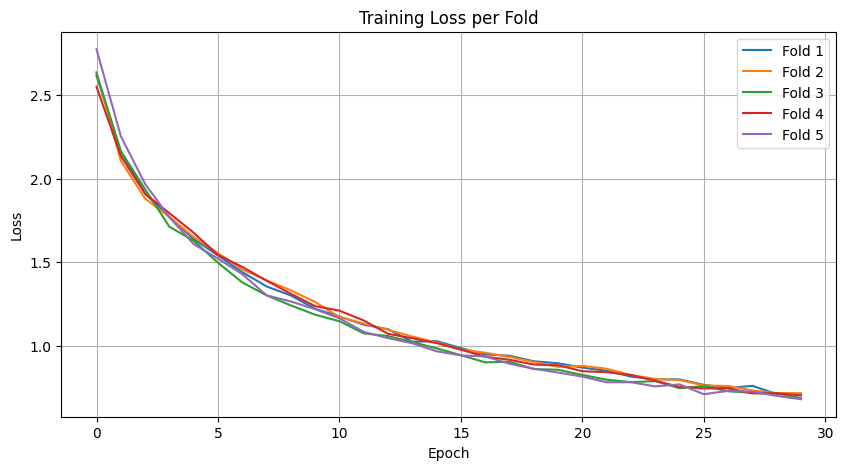

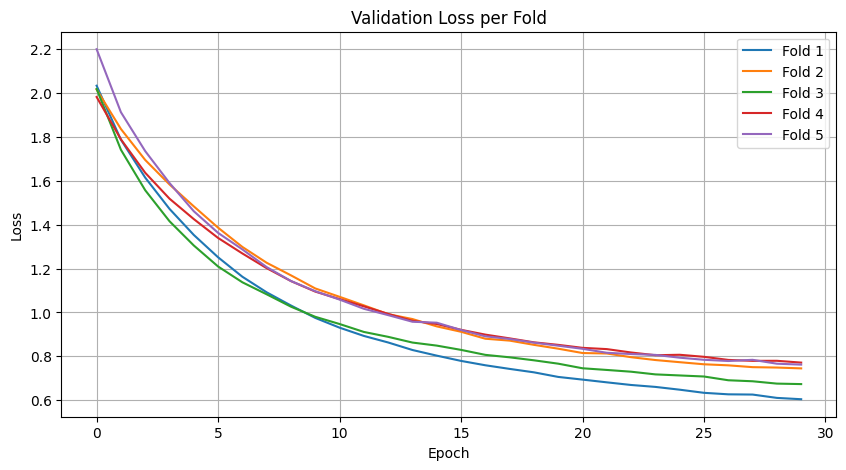

In [74]:
# Plot individual folds loss
plot_individual_folds(all_train_loss, 'Training Loss per Fold', 'Loss')
plot_individual_folds(all_val_loss, 'Validation Loss per Fold', 'Loss')

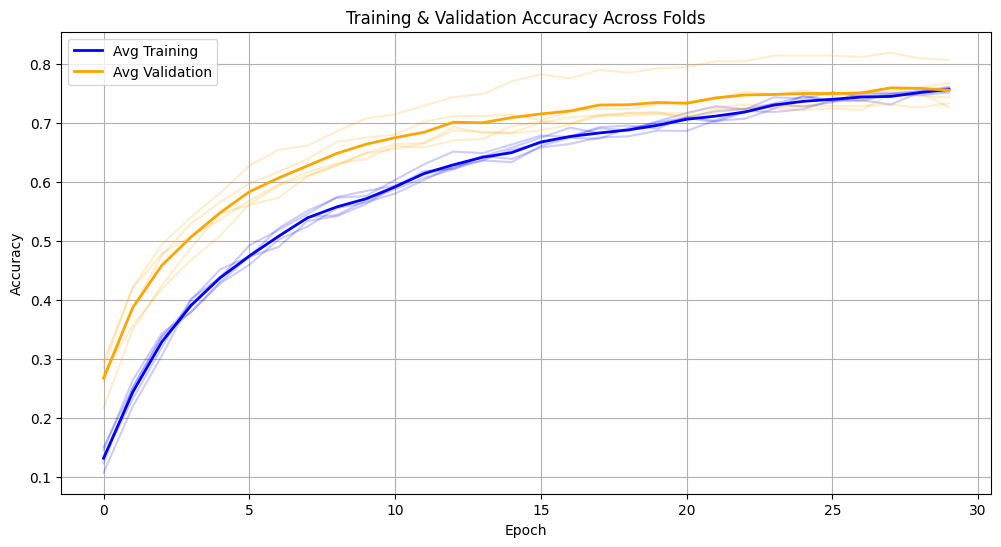

In [75]:
plot_overlaid_folds(all_train_acc, all_val_acc, 'Accuracy')

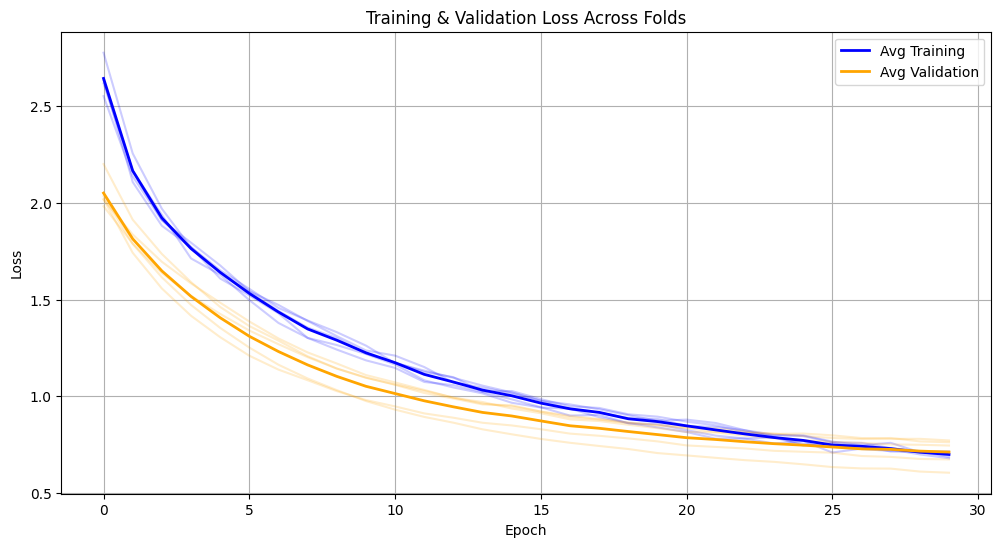

In [76]:
plot_overlaid_folds(all_train_loss, all_val_loss, 'Loss')